In [226]:
import sys
import os

import numpy as np
import pandas as pd
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt
from sqlalchemy import select

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), ".."))) 

from src.database.base import reflect_existing_table
from src.database.session import Database
from src.utils.data import get_ph_holidays

import nest_asyncio
import asyncio

nest_asyncio.apply()

async def fetch_transportation_data():
    Database.connect_async_session()
    async for session in Database.get_async_session():
        expenses_table = await reflect_existing_table("expenses")
        categories_table = await reflect_existing_table("categories")

        join_stmt = (
            select(
                expenses_table.c.date_spent,
                expenses_table.c.amount,
            )
            .select_from(
                expenses_table.join(
                    categories_table, expenses_table.c.category_id == categories_table.c.id
                )
            )
            .where(categories_table.c.name == "Transportation")
            .order_by(expenses_table.c.date_spent)
        )

        result = await session.execute(join_stmt)
        rows = result.fetchall()

        df = pd.DataFrame(rows, columns=["date_spent", "amount"])
        return df

loop = asyncio.get_event_loop()
df = loop.run_until_complete(fetch_transportation_data())

Aggregate raw daily expense data and fill missing dates

In [227]:
df["date_spent"] = pd.to_datetime(df["date_spent"]).dt.date
df["amount"] = df["amount"].astype(float)

daily_expense = df.groupby("date_spent", as_index=False).agg(
    total_amount=("amount", "sum")
)

full_date_range = pd.date_range(
    start=daily_expense["date_spent"].min(),
    end=daily_expense["date_spent"].max(),
    freq="D",
)

# Fill missing dates
daily_expense = (
    daily_expense.set_index("date_spent")
    .reindex(full_date_range)
    .rename_axis("date_spent")
    .reset_index()
)

daily_expense

,date_spent,total_amount
0,2025-08-06,120.0
1,2025-08-07,120.0
2,2025-08-08,120.0
3,2025-08-09,120.0
4,2025-08-10,45.0
...,...,...
174,2026-01-27,85.0
175,2026-01-28,135.0
176,2026-01-29,105.0
177,2026-01-30,135.0


Amount Feature

In [228]:
# Fill missing dates with 0 amount, indicating missing data -> no transportation or absent day, instead of unknown
daily_expense["total_amount"] = daily_expense["total_amount"].fillna(0.0)

daily_expense["has_spend"] = (daily_expense["total_amount"] > 0).astype(int)

Calendar Feature

In [229]:
# Calendar Features (Holiday & Weekends)
daily_expense["weekend"] = (daily_expense["date_spent"].dt.weekday == 6).astype(int)

ph_holidays = get_ph_holidays(years=daily_expense["date_spent"].dt.year.unique())

date_as_date = daily_expense["date_spent"].dt.date
daily_expense["holiday"] = date_as_date.isin(ph_holidays).astype(int)
daily_expense["holiday_name"] = date_as_date.map(ph_holidays)


daily_expense

,date_spent,total_amount,has_spend,weekend,holiday,holiday_name
0,2025-08-06,120.0,1,0,0,NaN
1,2025-08-07,120.0,1,0,0,NaN
2,2025-08-08,120.0,1,0,0,NaN
3,2025-08-09,120.0,1,0,0,NaN
4,2025-08-10,45.0,1,1,0,NaN
...,...,...,...,...,...,...
174,2026-01-27,85.0,1,0,0,NaN
175,2026-01-28,135.0,1,0,0,NaN
176,2026-01-29,105.0,1,0,0,NaN
177,2026-01-30,135.0,1,0,0,NaN


Rolling Amount Feature

In [230]:
daily_expense["rolling_mean_7d"] = (
    daily_expense["total_amount"].rolling(7, min_periods=1).mean()
)

# daily_expense["rolling_mean_14d"] = (
#     daily_expense["total_amount"].rolling(14, min_periods=1).mean()
# )

# daily_expense["rolling_mean_30d"] = (
#     daily_expense["total_amount"].rolling(30, min_periods=1).mean()
# )

daily_expense

,date_spent,total_amount,has_spend,weekend,holiday,holiday_name,rolling_mean_7d
0,2025-08-06,120.0,1,0,0,NaN,120.000000
1,2025-08-07,120.0,1,0,0,NaN,120.000000
2,2025-08-08,120.0,1,0,0,NaN,120.000000
3,2025-08-09,120.0,1,0,0,NaN,120.000000
4,2025-08-10,45.0,1,1,0,NaN,105.000000
...,...,...,...,...,...,...,...
174,2026-01-27,85.0,1,0,0,NaN,62.857143
175,2026-01-28,135.0,1,0,0,NaN,70.000000
176,2026-01-29,105.0,1,0,0,NaN,65.714286
177,2026-01-30,135.0,1,0,0,NaN,85.000000


In [231]:
daily_expense["avg_spend_per_active_day_30d"] = (
    daily_expense["total_amount"]
    .rolling(30, min_periods=1)
    .sum() / daily_expense["has_spend"]
    .rolling(30, min_periods=1)
    .sum()
    .replace(0, np.nan)
)

df = daily_expense.copy()
df["year_month"] = df["date_spent"].dt.to_period("M")
df["month_name"] = df["date_spent"].dt.strftime("%B")

monthly = df.groupby("year_month").agg(
    # month_name=("month_name", "first"),
    total_amount=("total_amount", "sum"),                     # TARGET
    active_days=("has_spend", "sum"),
    weekend_ratio=("weekend", "mean"),
    holiday_days=("holiday", "sum"),
    rolling_mean_7d=("rolling_mean_7d", "mean"),
    avg_spend_intensity=("avg_spend_per_active_day_30d", "mean"),
)

monthly

,total_amount,active_days,weekend_ratio,holiday_days,rolling_mean_7d,avg_spend_intensity
year_month,,,,,,
2025-08,1855.0,17,0.153846,2,81.405678,114.138812
2025-09,3234.0,24,0.133333,0,99.752381,125.585359
2025-10,2420.0,21,0.129032,1,80.714286,120.161962
2025-11,2627.0,22,0.166667,2,90.304762,121.730074
2025-12,2917.0,24,0.129032,5,96.193548,119.223104
2026-01,2055.0,19,0.129032,1,56.843318,106.934501


Total Amount Metrics Overtime

In [232]:
plt.rcParams["figure.figsize"] = (8, 4)

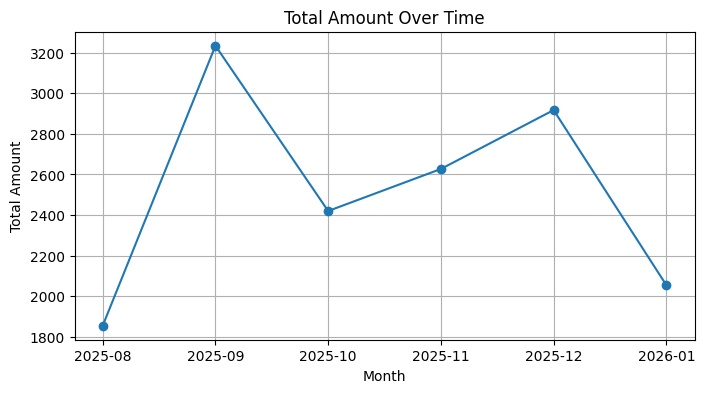

In [233]:
plt.plot(monthly.index.astype(str), monthly["total_amount"], marker="o")
plt.title("Total Amount Over Time")
plt.xlabel("Month")
plt.ylabel("Total Amount")
plt.grid(True)
plt.show()

Lag Validation

In [234]:
monthly["lag_1m"] = monthly["total_amount"].shift(1)

monthly["lag_1m"] = monthly["lag_1m"].fillna(monthly["lag_1m"].median())

monthly

,total_amount,active_days,weekend_ratio,holiday_days,rolling_mean_7d,avg_spend_intensity,lag_1m
year_month,,,,,,,
2025-08,1855.0,17,0.153846,2,81.405678,114.138812,2627.0
2025-09,3234.0,24,0.133333,0,99.752381,125.585359,1855.0
2025-10,2420.0,21,0.129032,1,80.714286,120.161962,3234.0
2025-11,2627.0,22,0.166667,2,90.304762,121.730074,2420.0
2025-12,2917.0,24,0.129032,5,96.193548,119.223104,2627.0
2026-01,2055.0,19,0.129032,1,56.843318,106.934501,2917.0


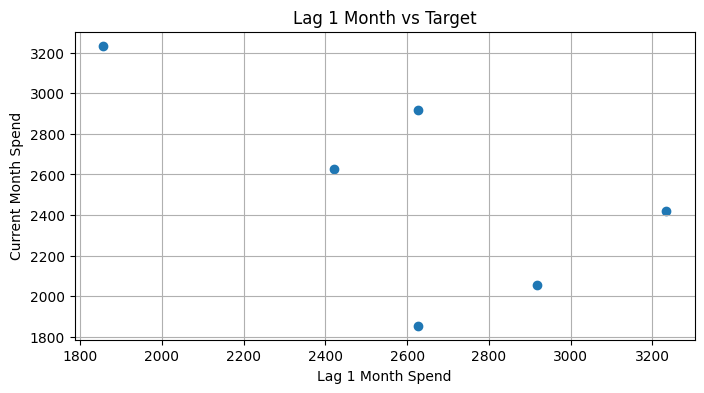

In [235]:
plt.scatter(monthly["lag_1m"], monthly["total_amount"])
plt.title("Lag 1 Month vs Target")
plt.xlabel("Lag 1 Month Spend")
plt.ylabel("Current Month Spend")
plt.grid(True)
plt.show()

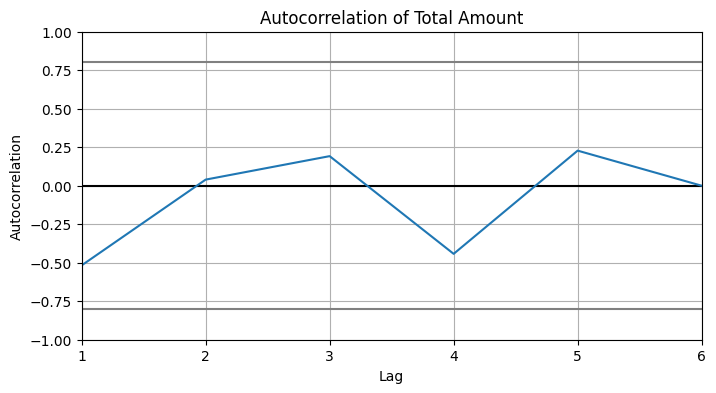

In [236]:
autocorrelation_plot(monthly["total_amount"])
plt.title("Autocorrelation of Total Amount")
plt.show()

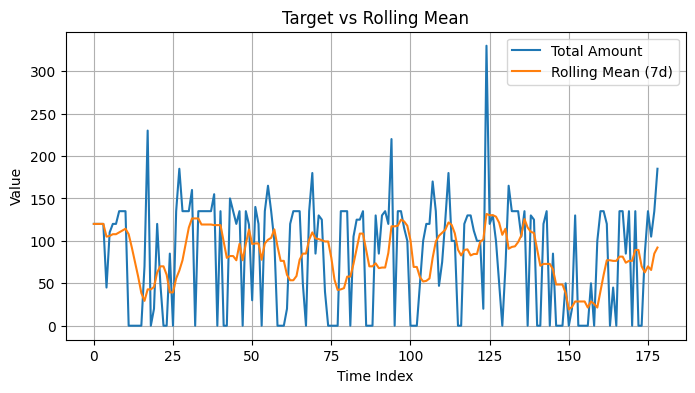

In [237]:
plt.plot(df.index, df["total_amount"], label="Total Amount")
plt.plot(df.index, df["rolling_mean_7d"], label="Rolling Mean (7d)")
plt.title("Target vs Rolling Mean")
plt.xlabel("Time Index")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()


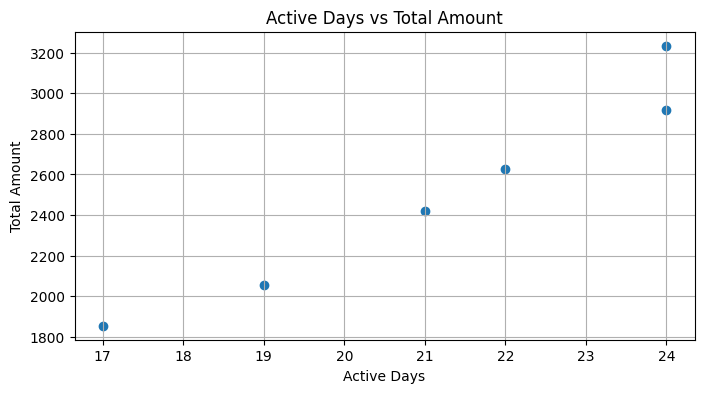

In [238]:
plt.scatter(monthly["active_days"], monthly["total_amount"])
plt.title("Active Days vs Total Amount")
plt.xlabel("Active Days")
plt.ylabel("Total Amount")
plt.grid(True)
plt.show()


In [239]:
corr = df.corr(numeric_only=True)["total_amount"].sort_values()
print(corr)

monthly

weekend                        -0.443109
holiday                        -0.208648
avg_spend_per_active_day_30d    0.127104
rolling_mean_7d                 0.346331
has_spend                       0.837477
total_amount                    1.000000
Name: total_amount, dtype: float64


,total_amount,active_days,weekend_ratio,holiday_days,rolling_mean_7d,avg_spend_intensity,lag_1m
year_month,,,,,,,
2025-08,1855.0,17,0.153846,2,81.405678,114.138812,2627.0
2025-09,3234.0,24,0.133333,0,99.752381,125.585359,1855.0
2025-10,2420.0,21,0.129032,1,80.714286,120.161962,3234.0
2025-11,2627.0,22,0.166667,2,90.304762,121.730074,2420.0
2025-12,2917.0,24,0.129032,5,96.193548,119.223104,2627.0
2026-01,2055.0,19,0.129032,1,56.843318,106.934501,2917.0
